## Лабораторная работа № 4

Вам предоставлены данные с описанием ситуации в странах, данные содержат следующую информацию:

- country - название страны
- child_mort - cмертность детей в возрасте до 5 лет на 1000 живорождений
- exports - экспорт товаров и услуг на душу населения. Приведено в % от ВВП на душу населения
- health - общие расходы на здравоохранение на душу населения. Указаны как % от ВВП на душу населения
- Imports - импорт товаров и услуг на душу населения. Указано в % от ВВП на душу населения.
- Income - чистый доход на человека
- Inflation - измерение годового темпа роста общего ВВП
- life_expec - ожидаемая продолжительность жизни
- total_fer - ожидаемая рождаемость 
- gdpp - ВВП на душу населения


Представьте, что вы анализируйте данные для международной благотворительной организации, которая оказывает поддержку наиболее нуждающимся странам, на основе этих данных выберите страны, которым помощь нужна в первую очередь.


1) Анализ и предобработка.
- Проанализировать данные (EDA).
- Предобработать данные.
- Скалировать/нормализовать данные.
2) Решите задачу с помощью следующих методов:
- K-means/mini batch k means
- Иерархическая кластеризация
- DBSCAN
3) Для каждого метода определить оптимальное количество кластеров (построить график)
4) Сделайте выводы, определите, каким странам нужно помогать в первую очередь. Опишите выделенные кластеры. Опишите эталонную страну в каждом кластере. 


#### 1) Анализ и предобработка:

In [249]:
import pandas as pd 

data = pd.read_csv('data.csv')
data_res = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


##### Гистограммы 

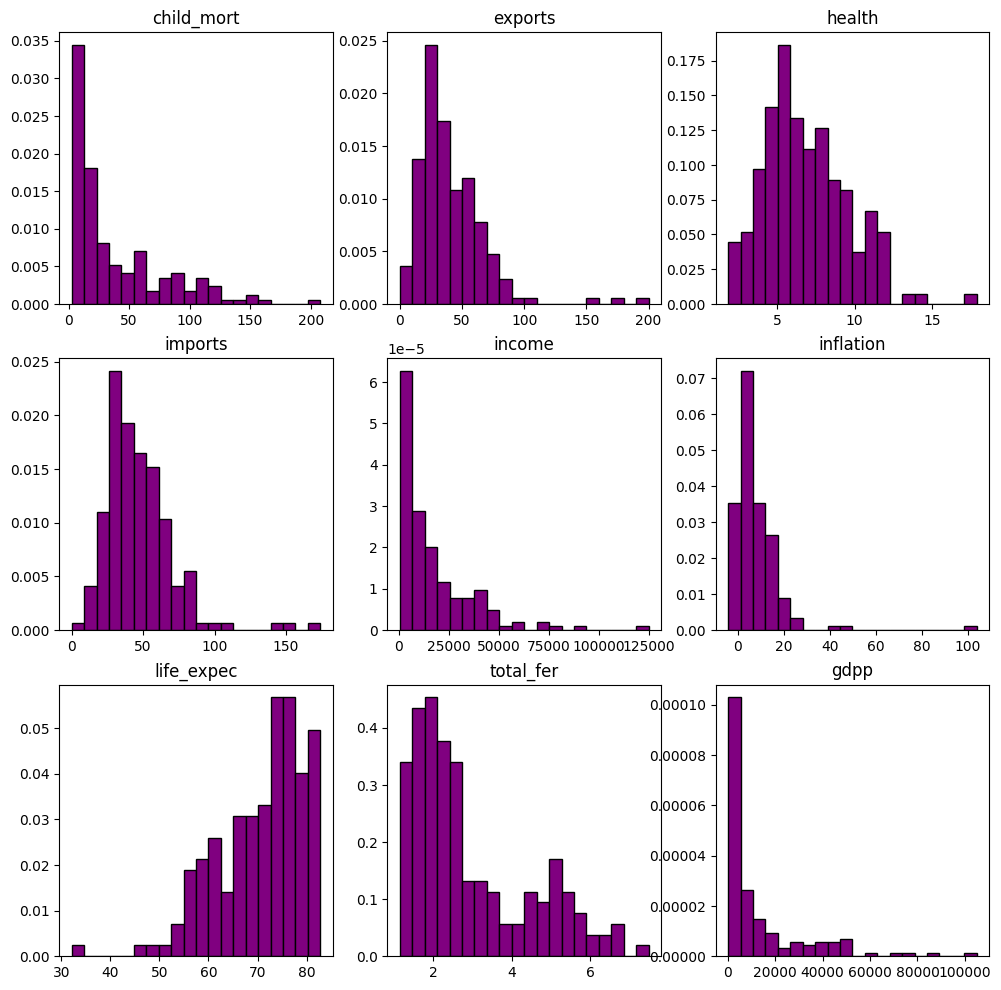

In [250]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
i = 1
for column in data.columns:
    if column != 'country':
        plt.subplot(3, 3, i)
        plt.hist(data[column], density=True, color = 'purple', edgecolor = 'black', bins=20)
        plt.title(column)
        i += 1
plt.show()

По гистограммам видно, что некторые признаки имеют распределение, похожее на экспотенциальное (child_mort, income, gdpp), на нормальное (exports, health, imports, inflation), на сумму 2-х нормальных распределений с 2-мя пиками (total_fer) и на урезанное нормальное (life_expec)

##### Ящики с усами 

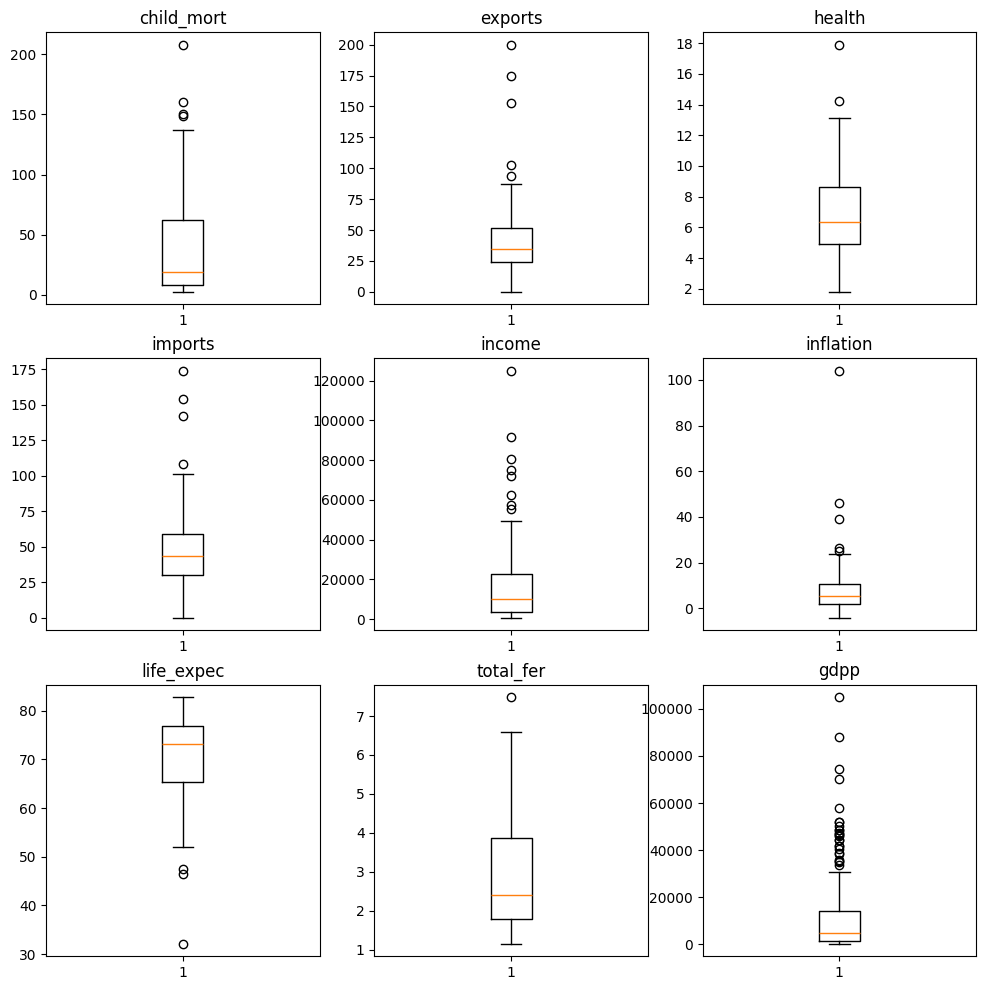

In [251]:
plt.figure(figsize=(12,12))
i = 1
for column in data.columns:
    if column != 'country':
        plt.subplot(3, 3, i)
        plt.boxplot(data[column])
        plt.title(column)
        i += 1
plt.show()

По ящикам с усами видно, что все признаки имеют выбросы. Обрабатывать выбросы будем следующим образом: 
- для признаков exports, health, imports, inflation, life_expec, total_fer заменим выбросы на граничные значения;
- к признакам child_mort, income и gdpp применим логарифмирование 

In [252]:
import numpy as np 

columns_max = ['exports', 'health', 'imports', 'inflation', 'life_expec', 'total_fer']
columns_to_log = ['child_mort', 'income', 'gdpp']

for column in columns_max:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data.loc[data[column] > upper_bound, column] = upper_bound
    data.loc[data[column] < lower_bound, column] = lower_bound

for column in columns_to_log:
    data[column] = np.log1p(data[column])

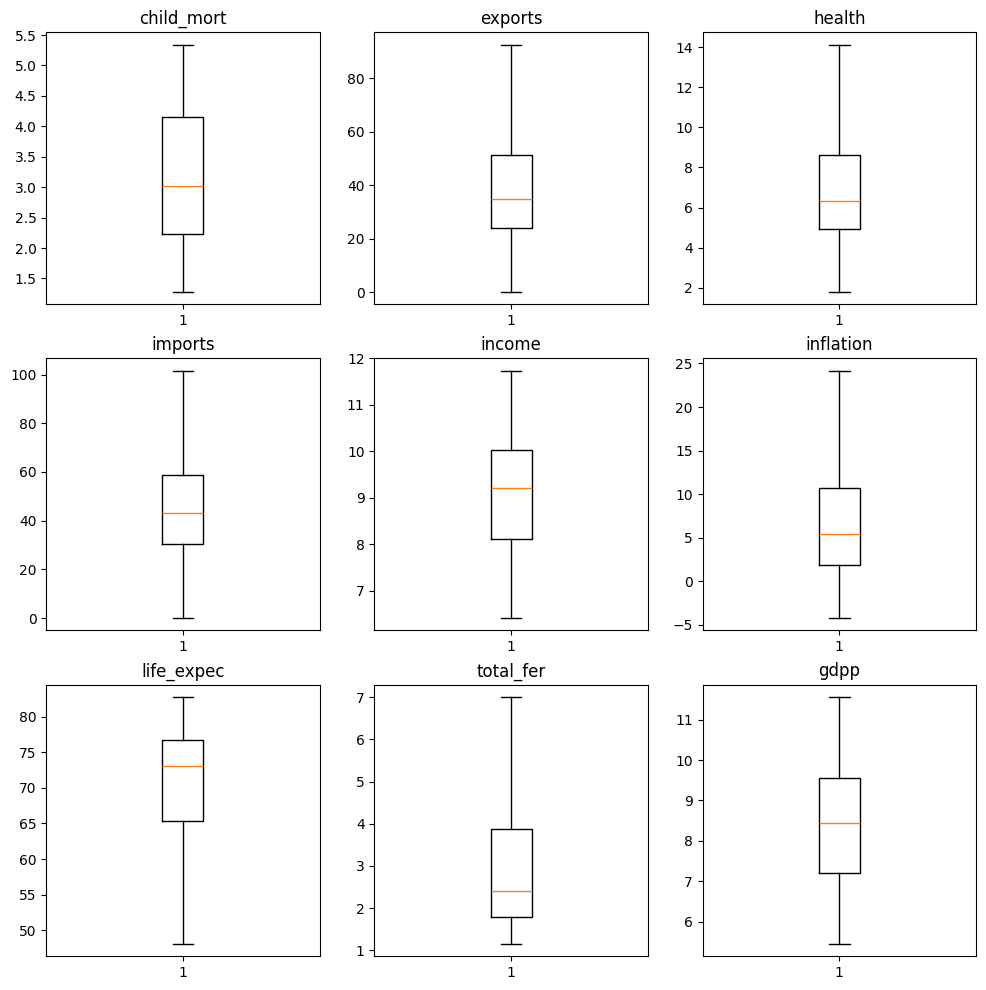

In [155]:
plt.figure(figsize=(12,12))
i = 1
for column in data.columns:
    if column != 'country':
        plt.subplot(3, 3, i)
        plt.boxplot(data[column])
        plt.title(column)
        i += 1
plt.show()

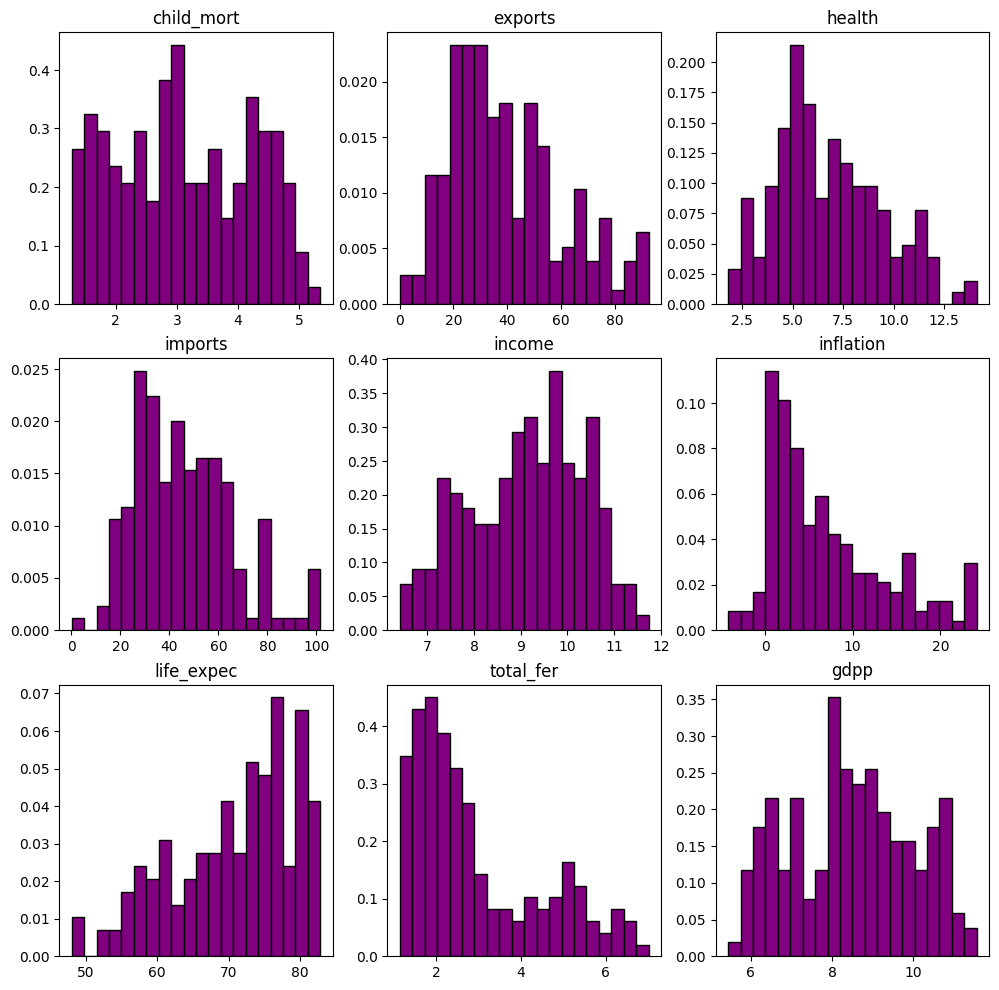

In [253]:
plt.figure(figsize=(12,12))
i = 1
for column in data.columns:
    if column != 'country':
        plt.subplot(3, 3, i)
        plt.hist(data[column], density=True, color = 'purple', edgecolor = 'black', bins=20)
        plt.title(column)
        i += 1
plt.show()

##### Тепловая карта

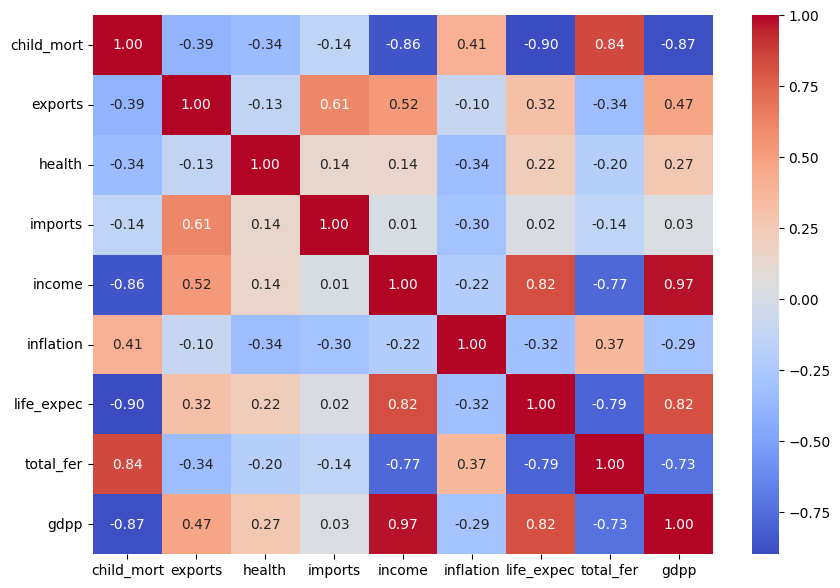

In [254]:
import seaborn as sns

corr_matrix = data.loc[:, data.columns != 'country'].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

По тепловой карте видно, что некторые признаки (child_mort с income, life_expec, total_fer и gdpp; income с life_expec и gdpp; life_expec с total_fer и gdpp) сильно коррелированы между собой, поэтому для дальнейшего обучения будем использовать не все из них.

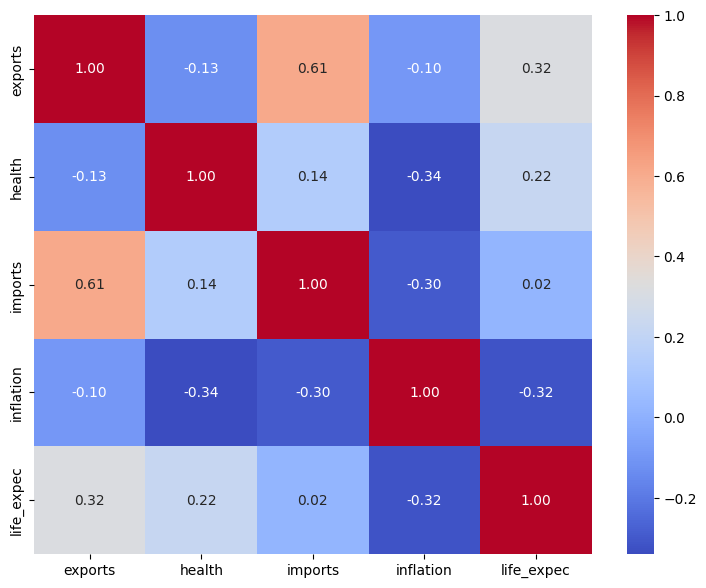

In [255]:
data = data.drop(columns=['child_mort', 'income', 'total_fer', 'gdpp', 'total_fer'])
corr_matrix = data.loc[:, data.columns != 'country'].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

##### Нормализация данных 

In [256]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_to_scale = [col for col in data.columns if col != 'country']
df = scaler.fit_transform(data[features_to_scale])
df = pd.DataFrame(df, columns=features_to_scale, index=data.index)
df['country'] = data['country']
df

,exports,health,imports,inflation,life_expec,country
0,0.106853,0.468725,0.441676,0.481142,0.234532,Afghanistan
1,0.301309,0.385053,0.478126,0.306662,0.812950,Albania
2,0.413662,0.191714,0.308683,0.715897,0.818705,Algeria
3,0.671856,0.084484,0.421973,0.937963,0.346763,Angola
4,0.490364,0.342811,0.579594,0.199154,0.827338,Antigua and Barbuda
...,...,...,...,...,...,...
162,0.502247,0.279448,0.518516,0.240747,0.430216,Vanuatu
163,0.306711,0.251828,0.172734,1.000000,0.787050,Venezuela
164,0.776646,0.408611,0.789428,0.574903,0.720863,Vietnam
165,0.322916,0.273761,0.338237,0.980261,0.559712,Yemen


#### 2) K-means:

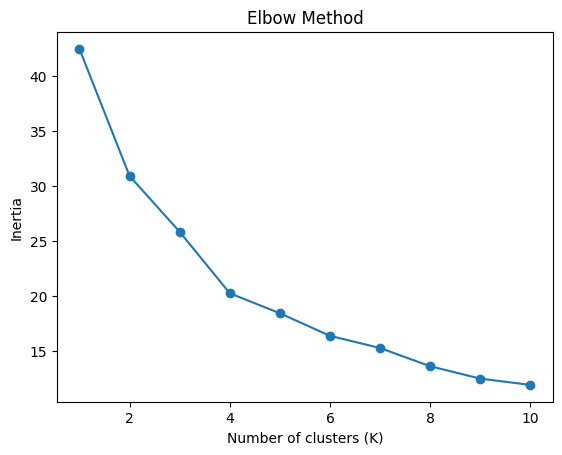

In [257]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df.loc[:, df.columns != 'country'])
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

К сожалению, с помощью Elbow Method не удалось определить оптимальное количество кластеров

K=2, Silhouette Score=0.250
K=3, Silhouette Score=0.247
K=4, Silhouette Score=0.269
K=5, Silhouette Score=0.244
K=6, Silhouette Score=0.217
K=7, Silhouette Score=0.238
K=8, Silhouette Score=0.254
K=9, Silhouette Score=0.238
K=10, Silhouette Score=0.240


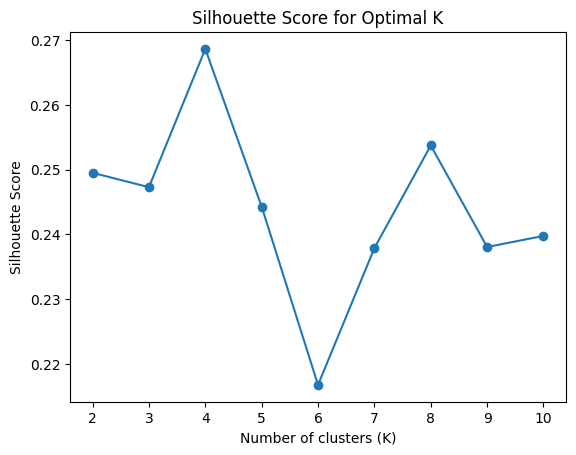

In [258]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df.loc[:, df.columns != 'country'])
    score = silhouette_score(df.loc[:, df.columns != 'country'], labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.3f}")

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

С помощью Silhouette Score можно сказать, что оптимальное количество кластеров k = 4

In [259]:
kmeans = KMeans(n_clusters=4)
df['cluster_kmeans'] = kmeans.fit_predict(df.loc[:, df.columns != 'country'])
df

,exports,health,imports,inflation,life_expec,country,cluster_kmeans
0,0.106853,0.468725,0.441676,0.481142,0.234532,Afghanistan,1
1,0.301309,0.385053,0.478126,0.306662,0.812950,Albania,2
2,0.413662,0.191714,0.308683,0.715897,0.818705,Algeria,3
3,0.671856,0.084484,0.421973,0.937963,0.346763,Angola,3
4,0.490364,0.342811,0.579594,0.199154,0.827338,Antigua and Barbuda,0
...,...,...,...,...,...,...,...
162,0.502247,0.279448,0.518516,0.240747,0.430216,Vanuatu,1
163,0.306711,0.251828,0.172734,1.000000,0.787050,Venezuela,3
164,0.776646,0.408611,0.789428,0.574903,0.720863,Vietnam,0
165,0.322916,0.273761,0.338237,0.980261,0.559712,Yemen,3


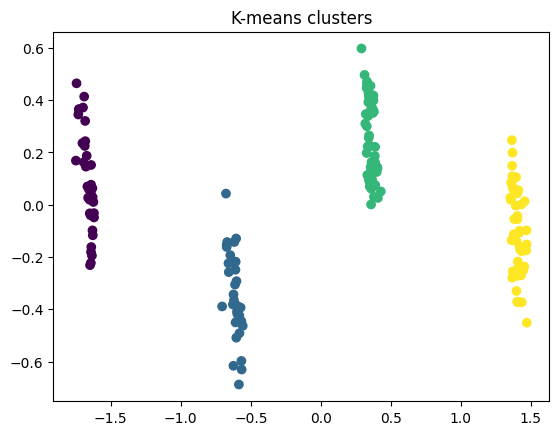

In [263]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df.loc[:, df.columns != 'country'])
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster_kmeans'])
plt.title('K-means clusters')
plt.show()

Чтобы описать эталонную страну в каждом кластере, для каждого кластера найдем страну, ближайшую к центроиду

In [264]:
centroids = kmeans.cluster_centers_
representative_countries = []

for i in range(kmeans.n_clusters):
    cluster_data = df[df['cluster_kmeans'] == i]
    centroid = centroids[i]
    
    temp_data1 = cluster_data.loc[:, cluster_data.columns != 'country']
    temp_data = temp_data1.loc[:, temp_data1.columns != 'cluster_kmeans']

    distances = np.linalg.norm(temp_data - centroid, axis=1)
    representative_country = cluster_data.iloc[np.argmin(distances)]['country']
    print(f"Cluster {i}: Representative country = {representative_country}")
    representative_countries.append(representative_country)
    
print()
print(data_res[data_res['country'].isin(representative_countries)])

Cluster 0: Representative country = Lithuania
Cluster 1: Representative country = Burkina Faso
Cluster 2: Representative country = Croatia
Cluster 3: Representative country = Uzbekistan

          country  child_mort  exports  health  imports  income  inflation  \
25   Burkina Faso       116.0     19.2    6.74     29.6    1430      6.810   
41        Croatia         5.5     37.6    7.76     38.1   20100      0.821   
90      Lithuania         6.1     65.3    7.04     67.2   21100      2.380   
161    Uzbekistan        36.3     31.7    5.81     28.5    4240     16.500   

     life_expec  total_fer   gdpp  
25         57.9       5.87    575  
41         76.3       1.55  13500  
90         73.2       1.50  12000  
161        68.8       2.34   1380  


Таким образом, странам, определенным в кластер 1, нужно помогать в первую очередь. Это страны с высокой смертностью детей, низким ВВП на душу населения, низкой ожидаемой продолжительностью жизни, низким доходом на человека и т.д.

#### 3) Иерархическая кластеризация:

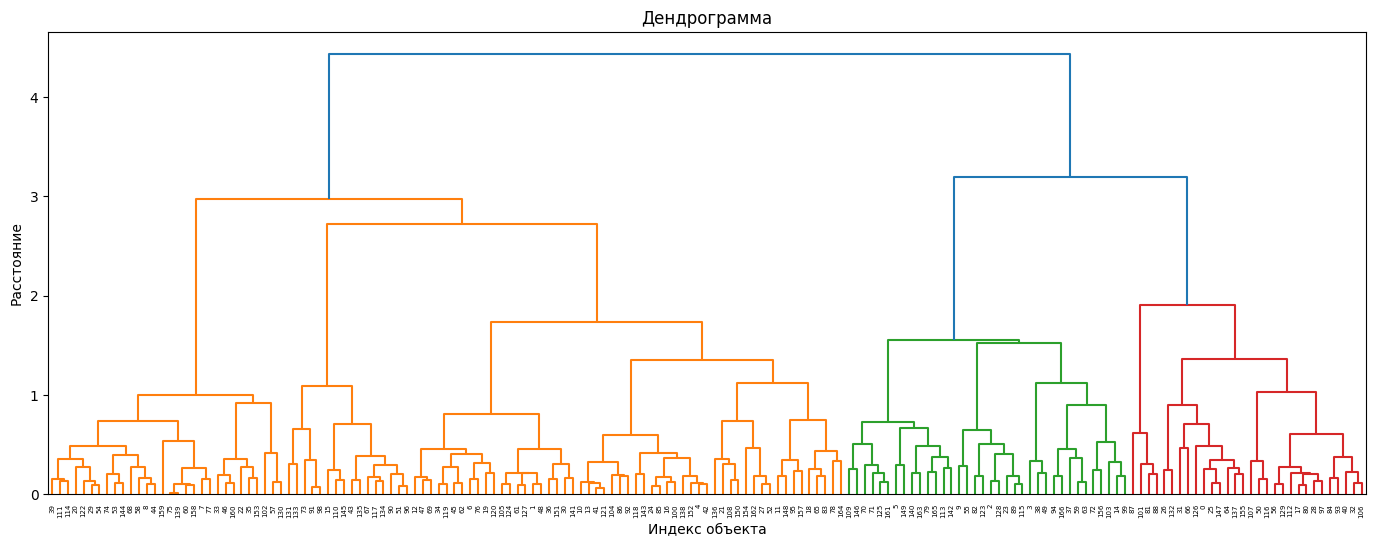

In [265]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs

Z = linkage(df.loc[:, ~df.columns.isin(['country', 'cluster_kmeans'])], method='ward')

# 3. Визуализация дендрограммы
plt.figure(figsize=(17, 6))
plt.title('Дендрограмма')
plt.xlabel('Индекс объекта')
plt.ylabel('Расстояние')
dendrogram(Z)
plt.show()

По виду дендограммы можно предположить, что оптимальное количество классов k = 5

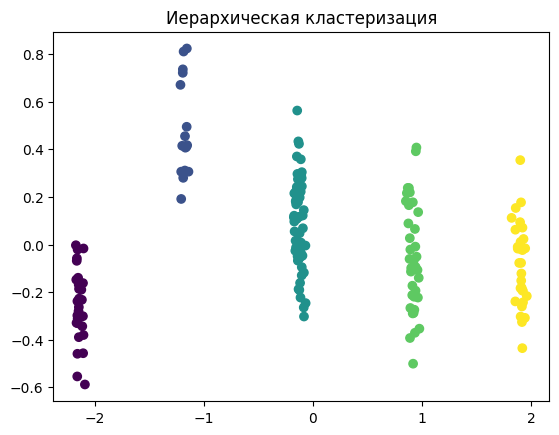

In [266]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, t=5, criterion='maxclust')
df['cluster_h'] = clusters

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df.loc[:, ~df.columns.isin(['country', 'cluster_kmeans'])])
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster_h'])
plt.title('Иерархическая кластеризация')
plt.show()

Для того чтобы найти эталонного страну для каждого кластера, найдем страну, которая ближе всего к центру своего кластера

In [267]:
from sklearn.metrics import pairwise_distances

typical_countries = []

for cluster_id in df['cluster_h'].unique():
    cluster_data = df[df['cluster_h'] == cluster_id].drop(['country', 'cluster_h', 'cluster_kmeans'], axis=1)
    
    centroid = cluster_data.mean(axis=0)
    
    distances = pairwise_distances(cluster_data, [centroid])
    representative_country = df.iloc[np.argmin(distances)]['country']
    typical_countries.append(representative_country)
    
    print(f"Cluster {cluster_id} {representative_country}:")

print()
print(data_res[data['country'].isin(typical_countries)])

Cluster 5 Algeria:
Cluster 3 Central African Republic:
Cluster 4 Belgium:
Cluster 1 Bosnia and Herzegovina:
Cluster 2 Barbados:

                     country  child_mort  exports  health  imports  income  \
2                    Algeria        27.3     38.4    4.17     31.4   12900   
13                  Barbados        14.2     39.5    7.97     48.7   15300   
15                   Belgium         4.5     76.4   10.70     74.7   41100   
20    Bosnia and Herzegovina         6.9     29.7   11.10     51.3    9720   
31  Central African Republic       149.0     11.8    3.98     26.5     888   

    inflation  life_expec  total_fer   gdpp  
2      16.100        76.5       2.89   4460  
13      0.321        76.7       1.78  16000  
15      1.880        80.0       1.86  44400  
20      1.400        76.8       1.31   4610  
31      2.010        47.5       5.21    446  


Таким образом, странам, определенным в кластер 3, нужно помогать в первую очередь. Это страны с высокой смертностью детей, низким ВВП на душу населения, низкой ожидаемой продолжительностью жизни, низким доходом на человека и т.д.

#### 4) DBSCAN:

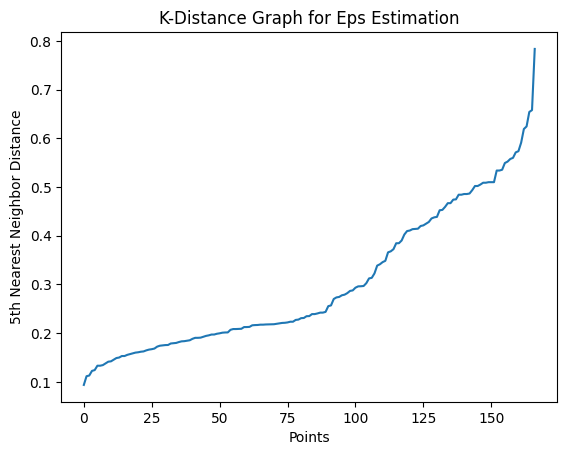

In [310]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5) 
nbrs = neigh.fit(df.loc[:, ~df.columns.isin(['country', 'cluster_kmeans', 'cluster_h'])])
distances, _ = nbrs.kneighbors(df.loc[:, ~df.columns.isin(['country', 'cluster_kmeans', 'cluster_h'])])
distances = np.sort(distances[:, -1], axis=0) 

plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("K-Distance Graph for Eps Estimation")
plt.show()

По графику можно предположить, что оптимальное значение eps = 0.55

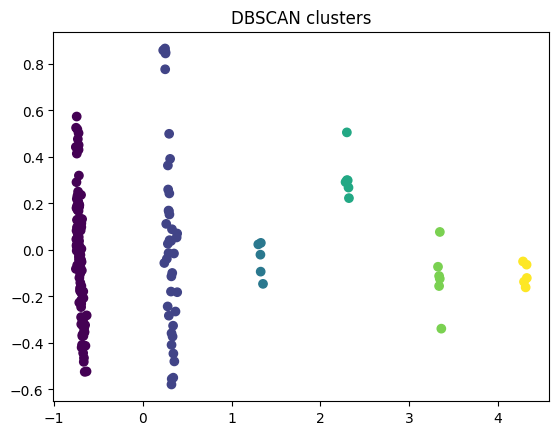

In [311]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.55, min_samples=5)
clusters = dbscan.fit_predict(df.loc[:, ~df.columns.isin(['country', 'cluster_kmeans', 'cluster_h'])])

df['cluster_dbscan'] = clusters

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df.loc[:, ~df.columns.isin(['country', 'cluster_kmeans', 'cluster_h'])])
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster_dbscan'])
plt.title('DBSCAN clusters')
plt.show()

Для того чтобы найти эталонного страну для каждого кластера, найдем страну, которая ближе всего к центру своего кластера

In [312]:
typical_countries = []

for cluster_id in df['cluster_dbscan'].unique():
    cluster_data = df[df['cluster_dbscan'] == cluster_id].drop(['country', 'cluster_h', 'cluster_kmeans', 'cluster_dbscan'], axis=1)
    
    centroid = cluster_data.mean(axis=0)
    
    distances = pairwise_distances(cluster_data, [centroid])
    representative_country = df.iloc[np.argmin(distances)]['country']
    typical_countries.append(representative_country)
    
    print(f"Cluster {cluster_id} {representative_country}:")

print()
print(data_res[data['country'].isin(typical_countries)])

Cluster 0 China:
Cluster 1 Congo, Dem. Rep.:
Cluster 2 Afghanistan:
Cluster 3 Albania:
Cluster 4 Argentina:
Cluster 5 Albania:

             country  child_mort  exports  health  imports  income  inflation  \
0        Afghanistan        90.2     10.0    7.58     44.9    1610       9.44   
1            Albania        16.6     28.0    6.55     48.6    9930       4.49   
5          Argentina        14.5     18.9    8.10     16.0   18700      20.90   
34             China        15.7     26.3    5.07     22.6    9530       6.94   
37  Congo, Dem. Rep.       116.0     41.1    7.91     49.6     609      20.80   

    life_expec  total_fer   gdpp  
0         56.2       5.82    553  
1         76.3       1.65   4090  
5         75.8       2.37  10300  
34        74.6       1.59   4560  
37        57.5       6.54    334  


Таким образом, странам, определенным в кластер 1, нужно помогать в первую очередь. Это страны с высокой смертностью детей, низким ВВП на душу населения, низкой ожидаемой продолжительностью жизни, низким доходом на человека и т.д.